Note : kuda matches backend to third party.

Imports

In [1]:
!pip install tqdm==4.65.0
!pip install imblearn  # Install the missing 'imblearn' package

In [2]:
from pathlib import Path
from google.colab import drive
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm

# @title Loading Required Packages
from pathlib import Path
from google.colab import drive
import pandas as pd
import numpy as np
import json
import ast
import re

import os
import pickle
import pandas as pd
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from imblearn.over_sampling import SMOTE

Load data

In [3]:
drive.mount('/content/gdrive',force_remount=True)


BASE_DIR=Path().resolve().parent
GDRIVE_MOUNT=BASE_DIR/"gdrive"
DATA_DIR = GDRIVE_MOUNT / "MyDrive/Kuda_ML_model/"

file_path = "/content/gdrive/MyDrive/Kuda_ML_model/Data/Input/kudaCombined2.zip"
!ls {file_path}

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/tmp')
    #!ls /tmp
    Kuda = pd.read_csv('/tmp/kudaCombined2.csv')

Kuda.head()


Mounted at /content/gdrive
/content/gdrive/MyDrive/Kuda_ML_model/Data/Input/kudaCombined2.zip


<ipython-input-3-3f3618a8d2f7>:14: DtypeWarning: Columns (20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  Kuda = pd.read_csv('/tmp/kudaCombined2.csv')


,id,transaction_date,value_date,transaction_type,amount,amount_currency,balance,balance_currency,matching_reference,reporting_tag,...,fsp_accounts,fsp_transaction_ids,backend_accounts,backend_transaction_ids,other_accounts,other_transaction_ids,metadata,tags,description,row_num
0,378403722,2024-09-10 10:58:22.000000 UTC,2024-09-10 10:58:22.000000 UTC,D,3.146824e+09,NGN,0.0,NGN,[199@1009202411013146823695.14],palmpay-settlement,...,NaN,NaN,NaN,NaN,NaN,NaN,"{transaction_date=2024-09-10 10:58:22, Instrum...",[palmpay-settlement],D|PALM PAY SETTLEMENT 09.09.2024|100920241101,1
1,382081596,2024-09-12 00:00:00.000000 UTC,2024-09-12 11:49:20.000000 UTC,D,3.585240e+09,NGN,0.0,NGN,[199@1209202412313585240145.97],palmpay-settlement,...,NaN,NaN,NaN,NaN,NaN,NaN,"{transaction_date=2024-09-12 11:49:20, Instrum...",[palmpay-settlement],D|PALM PAY SETTLEMENT 11.09.2024|120920241231,2
2,384671730,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,D,8.037985e+06,NGN,0.0,NGN,NaN,bank_settlement,...,NaN,NaN,NaN,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",D|NIP RETURN INWARD SESSION 1-3 04092024|ACC83...,1
3,384689168,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,C,8.060051e+08,NGN,0.0,NGN,NaN,bank_settlement,...,NaN,NaN,NaN,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",C|Kuda NIBSS EasyPay In 03.09.2024 SESSION 1-4...,2
4,384761220,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,C,1.293560e+06,NGN,0.0,NGN,NaN,bank_settlement,...,NaN,NaN,NaN,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",C|KUDA NIP BULK 04.09.2024|ACC83909240057,3


In [4]:
Kuda['reporting_tag'].value_counts()

,count
reporting_tag,
ni_settlements,200000
inward_success,200000
settlements,200000
CardPayments,200000
BillPayments,200000
bill_payments,200000
others,200000
outward_success,200000
bills,5202


In [5]:
Kuda1 = Kuda[0:600000]
Kuda2 = Kuda[600000:120000]
Kuda3 = Kuda[120000:]


In [6]:
Kuda = Kuda1
Kuda['reporting_tag'].value_counts()

,count
reporting_tag,
ni_settlements,94273
outward_success,82379
BillPayments,78209
CardPayments,75642
others,75258
inward_success,72350
settlements,62700
bill_payments,53093
bills,5202


## Preprocessing



*   Drop transactions with repoting_tag "others"
*   Drop transactions with reporting tags generated by llm
*   Create new col that combines description and transaction_type
*   List item





In [7]:
#@title Data Cleaning and Preprocessing step
def transform(df):
        # Filter data
        llm_pattern = re.compile(r'llm_prediction=([^,}]+)')
        df['llm_prediction'] = df['metadata'].apply(lambda x: llm_pattern.search(x).group(1) if llm_pattern.search(x) else 'None')
        df = df.loc[(df['reporting_tag'] != 'others') & (df['description'] != None) & (df['llm_prediction'] == 'None')]
        df_cleaned = df.dropna(axis=0, subset=['description'])

        # Clean and adjust tags
        df_cleaned['reporting_tag'] = (df_cleaned['reporting_tag']
                                       .str.replace("unknown_pattern", "", regex=False)
                                       .str.replace("no_ref", "", regex=False)
                                       .str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
                                       .str.lower())

        reversal_conditions = [
            (df_cleaned['reporting_tag'] == 'chargebacks') & (df_cleaned['transaction_type'] == "C"),
            (df_cleaned['reporting_tag'] == 'withdrawals') & (df_cleaned['transaction_type'] == "D")
        ]
        tag_choices = [tag + "_reversal" for tag in ['chargebacks', 'withdrawals']]
        df_cleaned['adjusted_reporting_tag'] = np.select(reversal_conditions, tag_choices, default=df_cleaned['reporting_tag'])
        return df_cleaned

def adjusted_description(df):
  df['description_con']=df.apply(lambda row: row['description']+"_"+"credit" if row['transaction_type']=="C" else row['description'], axis=1).str.lower()
  return df

In [8]:
## Application of the transformation functions

Kuda_semi_transformed = transform(Kuda)
Kuda_transformed = adjusted_description(Kuda_semi_transformed)

## DROPPING PALMPAY BEACUSE ITS SAMPLES ARE LESS THAN 6 WHICH IS THE MIN REQUIREMENT OF SMOTE
Kuda_transformed = Kuda_transformed[Kuda_transformed['adjusted_reporting_tag'] != 'palmpay-settlement']

print(Kuda_transformed.value_counts('adjusted_reporting_tag'))
Kuda_transformed.head()


<ipython-input-7-cef9474f3d3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['reporting_tag'] = (df_cleaned['reporting_tag']
<ipython-input-7-cef9474f3d3f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['adjusted_reporting_tag'] = np.select(reversal_conditions, tag_choices, default=df_cleaned['reporting_tag'])


adjusted_reporting_tag
billpayments         127300
nisettlements         94273
outwardsuccess        82379
cardpayments          75642
inwardsuccess         69950
settlements           62700
banksettlement          771
palmpaysettlement         2
Name: count, dtype: int64


,id,transaction_date,value_date,transaction_type,amount,amount_currency,balance,balance_currency,matching_reference,reporting_tag,...,backend_transaction_ids,other_accounts,other_transaction_ids,metadata,tags,description,row_num,llm_prediction,adjusted_reporting_tag,description_con
0,378403722,2024-09-10 10:58:22.000000 UTC,2024-09-10 10:58:22.000000 UTC,D,3.146824e+09,NGN,0.0,NGN,[199@1009202411013146823695.14],palmpaysettlement,...,NaN,NaN,NaN,"{transaction_date=2024-09-10 10:58:22, Instrum...",[palmpay-settlement],D|PALM PAY SETTLEMENT 09.09.2024|100920241101,1,None,palmpaysettlement,d|palm pay settlement 09.09.2024|100920241101
1,382081596,2024-09-12 00:00:00.000000 UTC,2024-09-12 11:49:20.000000 UTC,D,3.585240e+09,NGN,0.0,NGN,[199@1209202412313585240145.97],palmpaysettlement,...,NaN,NaN,NaN,"{transaction_date=2024-09-12 11:49:20, Instrum...",[palmpay-settlement],D|PALM PAY SETTLEMENT 11.09.2024|120920241231,2,None,palmpaysettlement,d|palm pay settlement 11.09.2024|120920241231
2,384671730,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,D,8.037985e+06,NGN,0.0,NGN,NaN,banksettlement,...,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",D|NIP RETURN INWARD SESSION 1-3 04092024|ACC83...,1,None,banksettlement,d|nip return inward session 1-3 04092024|acc83...
3,384689168,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,C,8.060051e+08,NGN,0.0,NGN,NaN,banksettlement,...,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",C|Kuda NIBSS EasyPay In 03.09.2024 SESSION 1-4...,2,None,banksettlement,c|kuda nibss easypay in 03.09.2024 session 1-4...
4,384761220,2024-09-05 00:00:00.000000 UTC,2024-09-05 14:45:15.000000 UTC,C,1.293560e+06,NGN,0.0,NGN,NaN,banksettlement,...,NaN,NaN,NaN,"{transaction_date=2024-09-05 14:45:15, Instrum...","[bank_settlement, no_ref]",C|KUDA NIP BULK 04.09.2024|ACC83909240057,3,None,banksettlement,c|kuda nip bulk 04.09.2024|acc83909240057_credit


In [9]:
# @title Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: colab_kernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit: headers, signatures,
                        and quoting.



## Model prep

In [10]:
# @title Split Data to test and train set
from time import time

xtrain,xtest,y_train,y_test=train_test_split(Kuda_transformed['description_con'],\
                                             Kuda_transformed['adjusted_reporting_tag'],test_size=0.3,random_state=42,\
                                             stratify=Kuda_transformed['adjusted_reporting_tag'])

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                              stop_words='english')
X_train = vectorizer.fit_transform(xtrain)

t0 = time()
X_test = vectorizer.transform(xtest)
duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(xtest)
duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

done in 1.831472s
n_samples: 359111, n_features: 567675

Extracting features from the test data using the same vectorizer
done in 1.359049s
n_samples: 153906, n_features: 567675



In [13]:
from imblearn.over_sampling import RandomOverSampler
from time import time
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Benchmark function with RandomOverSampler
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()

    # Determine the minimum number of samples in a class
    min_samples = y_train.value_counts().min()
    print(min_samples)

    # Replace SMOTE with RandomOverSampler due to difficulty with the number of neighbors in smote
    ros = RandomOverSampler(random_state=42)
    x_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    clf.fit(x_train_resampled, y_train_resampled)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    f1 = metrics.f1_score(y_test, pred, average='weighted')
    print("f1:   %0.3f" % f1)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=np.unique(np.concatenate((y_test, pred)))))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())

    # Train LinearSVC model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet")))

# Train Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

# LinearSVC with L1-based feature selection
print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))
])))


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:832: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 96.903s
test time:  0.045s
accuracy:   0.898
f1:   0.898
dimensionality: 567675
density: 1.000000

Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
1
train time: 16.653s
test time:  0.037s
accuracy:   0.891
f1:   0.884
dimensionality: 567675
density: 0.048572

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
1
train time: 20.092s
test time:  0.038s
accuracy:   0.902
f1:   0.897
dimensionality: 567675
density: 0.116060

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
1
train time: 103.618s
test time:  0.024s
accuracy:   0.902
f1:   0.897
dimensionality: 567675
density: 1.000000

________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50)
1
train time: 2

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


train time: 93.678s
test time:  0.080s
accuracy:   0.902
f1:   0.897



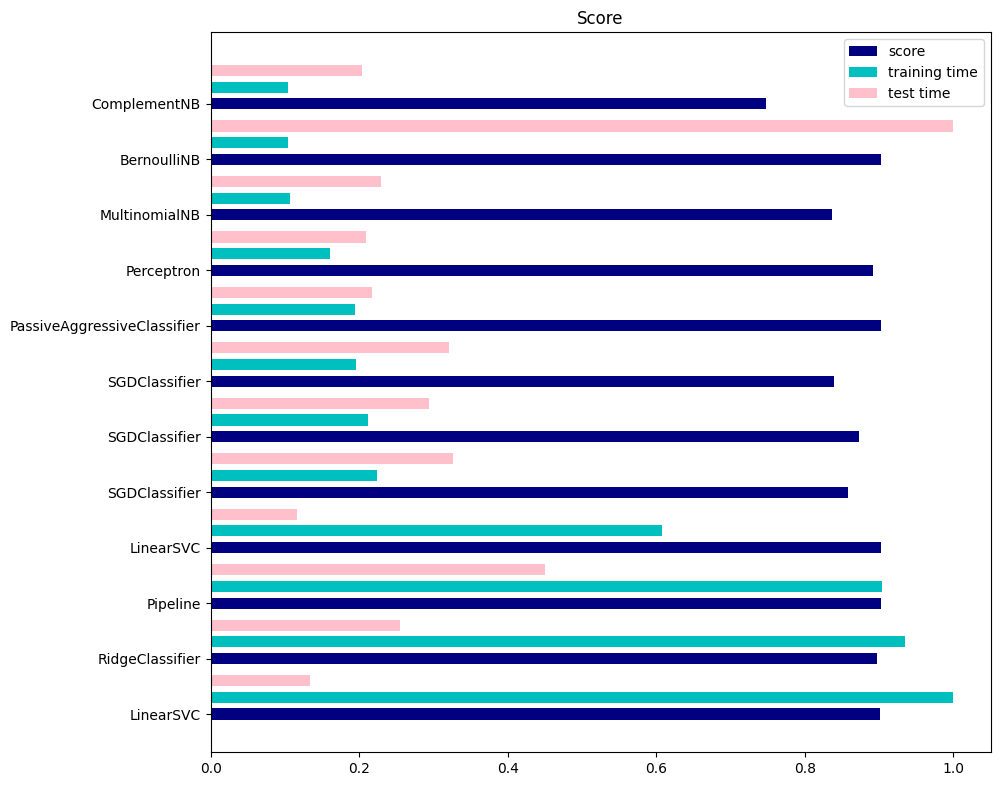

In [15]:
# @title Visualizing various ML accuracy, training time and test time
# Sort the results based on the shortest training time
results.sort(key=lambda x: x[2],reverse=True)  # x[2] refers to training_time

# Extract the sorted results
clf_names, score, training_time, test_time = [[x[i] for x in results] for i in range(4)]

# Normalize training and test times
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

# Plotting
plt.figure(figsize=(12, 8))
plt.title("Score")
indices = np.arange(len(results))
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time", color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='pink')
plt.yticks(indices, clf_names)  # Update y-ticks to display classifier names
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

plt.show()
